# TDI CAPSTONE PROJECT 

## Part 3 - Machine Learning

# TITLE: Share the road

### AUTHOR: Davide Cortesi

In [3]:
import seaborn as sns
sns.set()

import pandas as pd 
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

import pickle

`streets_and_weights.csv` contains the streets dataset with the addition of the weights computed on the past data. The code for getting can be found in the Part 2 notebook, 

In [4]:
df_streets = pd.read_csv('Data/streets_and_weights.csv')

## Prediction using street characteristics

In [5]:
to_analyze = ['borocode',
       'st_width', 'trafdir', 'rw_type', 'snow_pri', 'st_name',
       'shape_leng', 'bike_lane', 'bike_trafd',
       'lat_1', 'long_1', 'lat_2', 'long_2']
X = df_streets[to_analyze]
y = df_streets['weight']

In [15]:
# getting the middle point of the road 

class CoordsTransformer(BaseEstimator, TransformerMixin):
    """
    from starting point and end point of the street, 
    compute the mid-point to approimate position
    """
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['lat_mid'] = (X['lat_1'] + X['lat_2'])/2
        X['long_mid'] = (X['long_1'] + X['long_2'])/2
        X = X.drop(columns=['lat_1', 'lat_2', 'long_1', 'long_2'], axis=1)
        return X

class LaneChecker(BaseEstimator, TransformerMixin):
    """
    check is bike lane runs in the same sense as the street 
    """
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['lanes_direction'] = X[['trafdir', 'bike_trafd']].apply(compare, axis=1)
        return X
    
def compare(road):
    if road[1] == '0':
        return 'no_lane'
    elif road[1] == road[0]:
        return 'concord'
    else:
        return 'discord'
        

In [13]:
categorical = ['snow_pri', 'lanes_direction', 'rw_type']

numeric = ['borocode','st_width', 'bike_lane']

coords = ['lat_mid', 'long_mid']

encoder = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical),
    ('numeric', 'passthrough', numeric),
    #('coords', MinMaxScaler(), coords)
])

In [18]:
encoding_pipe = Pipeline([
    ('coords_transformer', CoordsTransformer()),
    ('lane_checker', LaneChecker()),
    ('encoder', encoder)
])

X_t = encoding_pipe.fit_transform(X)

/var/folders/3y/l8_jr0vx02l53_k2q_bglwb80000gp/T/ipykernel_66764/1711131048.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['lat_mid'] = (X['lat_1'] + X['lat_2'])/2
/var/folders/3y/l8_jr0vx02l53_k2q_bglwb80000gp/T/ipykernel_66764/1711131048.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['long_mid'] = (X['long_1'] + X['long_2'])/2


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import utils
from sklearn.ensemble import RandomForestRegressor

X_shuffle, y_shuffle = utils.shuffle(X_t, y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_shuffle, y_shuffle, test_size=0.33, random_state=42)

forest = RandomForestRegressor(random_state=42, max_depth=30, n_estimators=10)
forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=10, random_state=42)

In [21]:
y_pred_characteristics = forest.predict(X_test)

/Users/programming/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0, 0.5, 'Feature intensity')

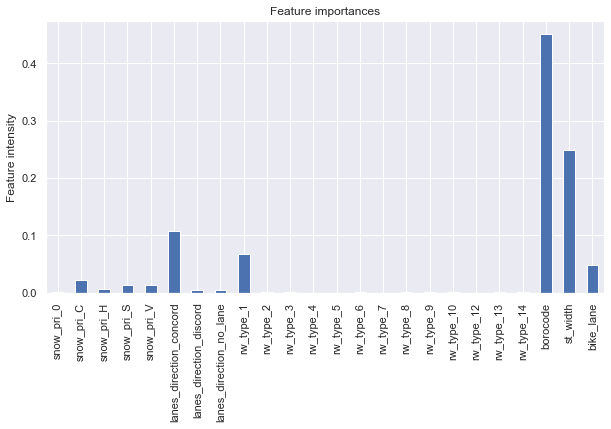

In [22]:
import matplotlib.pyplot as plt

encoded_features = list(encoder.named_transformers_.categorical.get_feature_names(categorical))
feature_names = encoded_features + numeric #+ coords

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,5))
forest_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Feature intensity')

## Prediction using seasonality

In [23]:
df_bike = pd.read_csv('Data/data_bike.csv')

In [24]:
import datetime

X = df_bike[['number_of_cyclist_injured', 'number_of_cyclist_killed', 'datetime']]

In [25]:
X['tot'] = X['number_of_cyclist_injured'] + X['number_of_cyclist_killed']
X['datetime'] = pd.to_datetime(X['datetime'])
X['date'] = X['datetime'].dt.date
X['hour'] = X['datetime'].dt.hour

day_series = X[['tot', 'date']].groupby('date').sum()


/var/folders/3y/l8_jr0vx02l53_k2q_bglwb80000gp/T/ipykernel_66764/771118730.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['tot'] = X['number_of_cyclist_injured'] + X['number_of_cyclist_killed']
/var/folders/3y/l8_jr0vx02l53_k2q_bglwb80000gp/T/ipykernel_66764/771118730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['datetime'] = pd.to_datetime(X['datetime'])
/var/folders/3y/l8_jr0vx02l53_k2q_bglwb80000gp/T/ipykernel_66764/771118730.py:3: SettingWithCopyWarning: 
A value is trying to be set on a

<AxesSubplot:xlabel='date'>

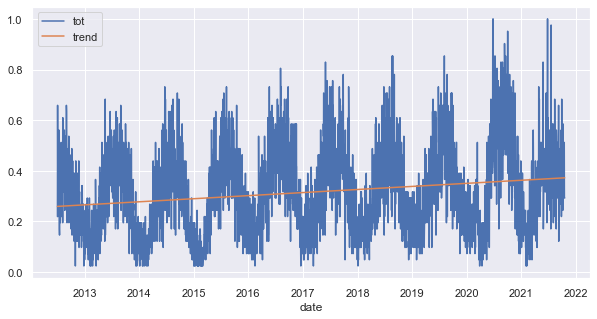

In [26]:
from sklearn.linear_model import LinearRegression

#add a constant feature for the trend
day_series['julian'] = pd.DatetimeIndex(day_series.index).to_julian_date()
day_series['const'] = pd.Series(np.ones(len(day_series.index)), index=day_series.index)
day_series['tot'] = day_series['tot']/(day_series['tot'].max())

trend = LinearRegression().fit(X=day_series[['const', 'julian']], y=day_series['tot'])
day_series['trend'] = trend.predict(day_series[['const', 'julian']])
day_series['diffusion'] = day_series['tot'] - day_series['trend']

fig, ax = plt.subplots(figsize=(10,5))
day_series[['tot', 'trend']].plot(ax=ax)

Text(0.5, 0.98, 'Fourier analysis')

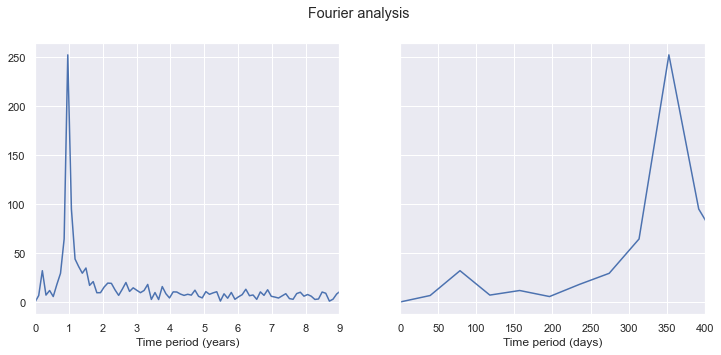

In [27]:
import scipy.fft

fft = scipy.fft.fft((day_series['diffusion'] - day_series['diffusion'].mean()).values)

year_range = (day_series.index.max() - day_series.index.min()).days/365.0

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].plot(1./year_range * np.arange(len(fft)), np.abs(fft))
axs[0].set_xlim([0,int(year_range)])
axs[0].set_xlabel('Time period (years)')


axs[1].plot(365./year_range * np.arange(len(fft)), np.abs(fft))
axs[1].set_xlim([0,400])
axs[1].set_xlabel('Time period (days)')

fig.suptitle('Fourier analysis')

In [28]:
# Fourier features
day_series['sin(year)'] = np.sin(day_series['julian'] / 365.25 * 2 * np.pi)
day_series['cos(year)'] = np.cos(day_series['julian'] / 365.25 * 2 * np.pi)
day_series['sin(3mo)'] = np.sin(day_series['julian'] / (365.25 / 4) * 2 * np.pi)
day_series['cos(3mo)'] = np.cos(day_series['julian'] / (365.25 / 4) * 2 * np.pi)

In [29]:
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(day_series[['julian', 'trend', 'sin(year)', 'cos(year)',
                                                               'sin(3mo)', 'cos(3mo)']],
                                                    day_series['tot'], test_size=0.3, shuffle=False)

fourier_predictor = Ridge(alpha=0.01)

fourier_predictor.fit(X_train, y_train)

y_pred = fourier_predictor.predict(X_test)

r2_score(y_test, y_pred)

0.44837294977653064

## Prediction using the hour

<AxesSubplot:xlabel='hour'>

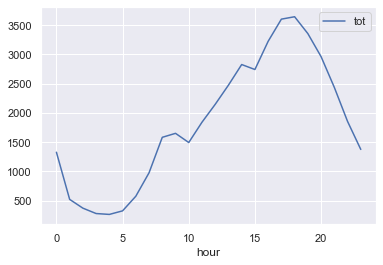

In [30]:
hour_series = X[['tot', 'hour']].groupby('hour').sum()
hour_series.plot()

In [31]:
from sklearn import base

class HourPredictor(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self):
        self.reference_dict = {}
    
    def fit(self, hour_series, y):
        self.reference_dict = (hour_series/hour_series.max()).to_dict()['tot']
        return self

    def predict(self, X):
        y_pred = X['hour'].replace(to_replace=self.reference_dict)
        return y_pred

In [32]:
hour_predictor = HourPredictor()

hour_predictor.fit(hour_series, None)

HourPredictor()

## Let's glue all togheter and try

The idea is to recompute the map of the risk for the streets segments based on the prediction we made. The risk score now is the predicted risk computed in the first part of this notebook. The day and the hour enter the computations as multiplicative coefficents. 

In [33]:
X = df_streets[to_analyze]
y = df_streets['weight']

X_t = encoding_pipe.fit_transform(X)
forest.fit(X_t, y)
new_weights = forest.predict(X_t)


/var/folders/3y/l8_jr0vx02l53_k2q_bglwb80000gp/T/ipykernel_66764/1711131048.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['lat_mid'] = (X['lat_1'] + X['lat_2'])/2
/var/folders/3y/l8_jr0vx02l53_k2q_bglwb80000gp/T/ipykernel_66764/1711131048.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['long_mid'] = (X['long_1'] + X['long_2'])/2


In [34]:
df_streets_new = df_streets
df_streets_new['weight'] = new_weights

In [35]:
from datetime import datetime

def update_map(date, hour):
    
    df_curr = df_streets_new
    
    if date:        
        # time-based-prediction
        date = datetime.strptime(date, '%d/%m/%Y')
        day_test = pd.DataFrame(index=[date])

        day_test['julian'] = pd.DatetimeIndex(day_test.index).to_julian_date()
        day_test['const'] = pd.Series(np.ones(len(day_test.index)), index=day_test.index)
        day_test['trend'] = trend.predict(day_test[['const', 'julian']])
        day_test['sin(year)'] = np.sin(day_test['julian'] / 365.25 * 2 * np.pi)
        day_test['cos(year)'] = np.cos(day_test['julian'] / 365.25 * 2 * np.pi)
        day_test['sin(3mo)'] = np.sin(day_test['julian'] / (365.25 / 4) * 2 * np.pi)
        day_test['cos(3mo)'] = np.cos(day_test['julian'] / (365.25 / 4) * 2 * np.pi)

        date_coeff = fourier_predictor.predict(day_test[['julian', 'trend', 'sin(year)', 'cos(year)', 'sin(3mo)', 'cos(3mo)']])[0]
    
    if date:        
        # hour-based-prediction
        hour = datetime.strptime(hour, '%H:%M').hour
        hour_test = pd.DataFrame([hour], index=[0], columns=['hour'])
        hour_coeff = hour_predictor.predict(hour_test)[0]
        
    df_curr['weight'] = df_curr['weight'] * date_coeff * hour_coeff
    
    return df_curr


In [36]:
update_map('16/10/2022', '19:00')

,Unnamed: 0,the_geom,physicalid,st_label,borocode,st_width,trafdir,rw_type,snow_pri,full_stree,...,shape_leng,bike_lane,bike_trafd,position_1,position_2,lat_1,long_1,lat_2,long_2,weight
0,0,"{'type': 'MultiLineString', 'coordinates': [[[...",3,BATTERY PL,1,42,TW,1,C,BATTERY PL,...,262.777812,0,0,"[-74.01793061274537, 40.706174865639746]","[-74.01786933958108, 40.70634871855222]",40.706175,-74.017931,40.706349,-74.017869,1.540864
1,1,"{'type': 'MultiLineString', 'coordinates': [[[...",5,BATTERY PL,1,42,TW,1,C,BATTERY PL,...,259.415989,0,0,"[-74.01757437049282, 40.706839867152155]","[-74.01712051881411, 40.70746253088075]",40.706840,-74.017574,40.707463,-74.017121,1.540864
2,2,"{'type': 'MultiLineString', 'coordinates': [[[...",6,BATTERY PL,1,42,TW,1,C,BATTERY PL,...,280.444781,0,0,"[-74.01712051881411, 40.70746253088075]","[-74.01662578576105, 40.708133934649545]",40.707463,-74.017121,40.708134,-74.016626,1.540864
3,3,"{'type': 'MultiLineString', 'coordinates': [[[...",8,BATTERY PL,1,42,TW,1,C,BATTERY PL,...,32.070139,0,0,"[-74.01693786186667, 40.704813986596974]","[-74.01704963744208, 40.70483662931333]",40.704814,-74.016938,40.704837,-74.017050,1.540864
4,4,"{'type': 'MultiLineString', 'coordinates': [[[...",14,BATTERY PL,1,24,TF,1,C,BATTERY PL,...,206.271850,0,0,"[-74.01428922948978, 40.70454907535253]","[-74.01437031212745, 40.704558037844706]",40.704549,-74.014289,40.704558,-74.014370,1.641192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120217,120217,"{'type': 'MultiLineString', 'coordinates': [[[...",193772,W 11 ST,1,30,FT,1,C,W 11 ST,...,890.835581,0,0,"[-73.99827418986168, 40.73539113958072]","[-74.00100243918403, 40.73654263256144]",40.735391,-73.998274,40.736543,-74.001002,2.367123
120218,120218,"{'type': 'MultiLineString', 'coordinates': [[[...",193773,W 11 ST,1,28,FT,1,C,W 11 ST,...,244.011626,0,0,"[-74.00109395779207, 40.736560232724436]","[-74.00126555338024, 40.73650164915443]",40.736560,-74.001094,40.736502,-74.001266,1.390861
120219,120219,"{'type': 'MultiLineString', 'coordinates': [[[...",193774,VAN WYCK EXPRESSWAY EXIT 7 SB,4,0,FT,9,C,I 678 EXIT 7 SB,...,794.210400,0,0,"[-73.82895450456604, 40.71484534131804]","[-73.82625020254362, 40.71556502334653]",40.714845,-73.828955,40.715565,-73.826250,0.050000
120220,120220,"{'type': 'MultiLineString', 'coordinates': [[[...",193781,BELT PKWY,3,32,TF,2,C,BELT PKWY,...,358.298231,0,0,"[-73.91297959961221, 40.58587205532756]","[-73.91190615839747, 40.58641745233693]",40.585872,-73.912980,40.586417,-73.911906,0.106901


In [37]:
pickle.dump(fourier_predictor, open('fourier_predictor', 'wb'))
pickle.dump(hour_predictor, open('hour_predictor', 'wb'))
pickle.dump(forest, open('street_predictor', 'wb'))